In [ ]:
import os 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt,exp,ceil,cos,acos,sin
from bisect import bisect
from matplotlib import pyplot
import pylab
import matplotlib.pyplot as plt
import random
import itertools
import gc

dir_path = os.getcwd()
upper_edge_limit=1.667
lower_dist_limit=0.707
movement_constant=30
angle_step=0.1
shadow_cutoff_1=0.8667
shadow_cutoff_2=1.2991
C_0=0.0
C_para=-20.0
C_per=0.0
ell=3.0
k_0= 10.0
k_per=0.0
k_para=5.0
looping=2
plot_intervals=100
saving_path=dir_path
numberofrun=(10**5)

def initialize_vertex():
    """
    Input: no input argument, returns 12 vertex points on a sphere
    """
    result=np.array([[0,0,0]],dtype=np.float64)
    phi=float((1+sqrt(5))/2)
    nor=sqrt(phi**2+1**2)
    phi/=nor
    c=1/nor
    for a,b in [(phi,c), (phi,-c),(-phi,c),(-phi,-c)]:
        result=np.concatenate((result,np.array([[0,b,a]],dtype=np.float64)))
        result=np.concatenate((result,np.array([[b,a,0]],dtype=np.float64)))
        result=np.concatenate((result,np.array([[a,0,b]],dtype=np.float64)))
    result=np.delete(result, 0, 0)
    return result

def distance(a):
    """
    Input: a:vertices,
    as input arguments, returns a numpy array[i][j] = distance from i to j
    """
    b=a.shape[0]
    results=np.zeros([b,b],dtype=np.float64)
    for i in range(b):
        for j in range(b):
            results[i][j]=sqrt((a[i][0]-a[j][0])**2+(a[i][1]-a[j][1])**2+(a[i][2]-a[j][2])**2)
    return results

def get_neighbours(a,b):
    """
    Input: a:vertices, b:distance from one vertex to another vertex
    as input arguments, returns a dictionary with vertex numbers as keys and a 
    sorted list [(other vertex no. , distance to the other vertex)]
    """
    c=a.shape[0]
    results={}
    for i in range(c):
        results[i]=[]
        for j in list(range(0,i))+list(range(i+1,c)):
            results[i]+=[(j,b[i][j])]
        results[i]=sorted(results[i], key=lambda x: x[1])
    return results

def vertex_shadow(a,b,c1=shadow_cutoff_1,c2=shadow_cutoff_2):
    """
    Input: a:vertices b: neighbours
    To define the interior point of each vertex for future purposes
    """
    results=np.zeros([a.shape[0],3],dtype=np.float64)
    for i in range(a.shape[0]): #for each vertex
        center1=np.array([0,0,0],dtype=np.float64)
        center2=np.array([0,0,0],dtype=np.float64)
        center3=np.array([0,0,0],dtype=np.float64)
        list_center1=[x for (x,y) in b[i] if y<c1]
        list_center2=[x for (x,y) in b[i] if y<c2]
        list_center3=[x for (x,y) in b[i]]
        
        for z in list_center1:
            center1+=a[z]
        center1/=float(len(list_center1))
        for z in list_center2:
            center2+=a[z]
        center2/=float(len(list_center2))
        for z in list_center3:
            center3+=a[z]
        center3/=float(len(list_center3))
        
        [test12,test13,test23]=[np.dot(center1,center2),np.dot(center1,center3),np.dot(center2,center3)]
        
        if test12>=0 and test13>=0 and test23>=0:
            interior=center1
        elif test12>=0 and test13>=0:
            interior=center1
        elif test12>=0 and test23>=0:
            interior=center2
        elif test13>=0 and test23>=0:
            interior=center3
        elif test13>=0:
            interior=center1
        elif test12>=0:
            interior=center2
        elif test23>=0:
            interior=center2
        else:
            interior=center3
        results[i]=a[i]+(1/100)*(interior-a[i])
    return results

def get_edges(a,b): 
    """
    Input: a:vertices b: dictionary with vertex as keys and (vertex, distances to other vertice) as sorted list sorted
    according to distance
    To find the 5 nearest vertex and record the edges
    """
    results=[]
    d=b.copy()
    for key in b:
        d[key]=d[key][0:5]
        for c in d[key]:
            temp=frozenset([key,c[0]])
            results.append(temp)
    results=list(set(results))
    return results

def get_triangles(a,b):
    """
    Input: a:vertices b: dictionary with vertex as keys and (vertex, distances to other vertice) as sorted list sorted
    according to distance
    To find the 5 nearest vertex and record the edges
    """
    d=b.copy()
    results=[]
    for key in d: #for each vertex
        for i in range(0,5): # for the five nearest vertex
            for j in (range(i+1,5)): #for the other of the five nearest vertex
                flag=0
                for k in range(0,5): #if the jth vertex is one of the 5 closest neighbours to the ith vertex
                    if d[key][j][0]==d[d[key][i][0]][k][0]:
                        flag=1
                if flag==1:
                    temp_tri=frozenset([key,d[key][i][0],d[key][j][0]]) #vertex of interest,
                    results.append(temp_tri)
    results=list(set(results))
    return results

def update_midpoints(a,b):
    """
    Input: a:vertices b: edges
    Output [new vertices, {edges: new vertice number}]
    """
    results1={}
    counter=a.shape[0]
    for c in b: #for each edge
        tc=list(c)
        temp1=a[tc[0]]+0.5*(a[tc[1]]-a[tc[0]])
        temp1=temp1/np.linalg.norm(temp1)
        a=np.concatenate((a,np.array([[temp1[0],temp1[1],temp1[2]]],dtype=np.float64)))
        results1[c]=counter
        counter+=1
        
    return [a,results1]

def update_triangles(a,b,c): 
    """
    Input: a:vertices b: triangles c:midpoints_with_edges
    Output: [new triangle, new edges]
    """
    results1=[]
    results2=[]
    for d in b: #For every triangle
        d=list(d)
        e1=frozenset([d[0],d[1]])
        e2=frozenset([d[0],d[2]])
        e3=frozenset([d[1],d[2]])
        results1.append(frozenset([d[0],c[e1],c[e2]]))
        results1.append(frozenset([d[1],c[e1],c[e3]]))
        results1.append(frozenset([d[2],c[e2],c[e3]]))
        results1.append(frozenset([c[e1],c[e2],c[e3]]))
        results2.append(frozenset([d[0],c[e1]]))
        results2.append(frozenset([c[e1],d[1]]))
        results2.append(frozenset([d[1],c[e3]]))
        results2.append(frozenset([c[e3],d[2]]))
        results2.append(frozenset([d[2],c[e2]]))
        results2.append(frozenset([c[e2],d[0]]))
        results2.append(frozenset([c[e1],c[e2]]))
        results2.append(frozenset([c[e2],c[e3]]))
        results2.append(frozenset([c[e3],c[e1]]))
    results2=list(set(results2))
    results1=list(set(results1))
    return [results1,results2]


def check_state(n):
    vn=12
    en=30
    tn=20

    for i in range(n):
        vnt=vn
        ent=en
        tnt=tn
        vn=vnt+ent
        en=ent*2+tn*3
        tn=tnt*4
    print("We current have %d vertices, %d edges and %d triangles" %(vertices.shape[0],len(edges),len(triangles)))
    print('The correct number of vertices, edges and triangles is %d, %d ,%d'%(vn,en,tn))
    print("The vertices shape is ",vertices.shape)
    print("The neighbours shape is ",len(neighbours))
    print("The edges shape is ",len(edges))
    print("The triangles shape is ",len(triangles))
    print("The vertices_property shape is ",len(vertices_property))
    print("The edges_property shape is ",len(edges_property))
    print("The triangle_property shape is ",len(triangle_property))
    return


def initialize_normal(a,b,c):
    """
    Input: a:vertices b:vertices_shadow c:triangle of interest
    Output: Outward normal vector
    """
    tc=list(c)
    temp=np.cross((a[tc[1]]-a[tc[0]]),(a[tc[2]]-a[tc[0]]))
    temp/=np.linalg.norm(temp) #normalized normal, may or may not be outward
    mid=a[tc[0]]+1.0/3.0*(a[tc[1]]-a[tc[0]])+1.0/3.0*(a[tc[2]]-a[tc[0]])
    mid_shadow=b[tc[0]]+1.0/3.0*(b[tc[1]]-b[tc[0]])+1.0/3.0*(b[tc[2]]-b[tc[0]])
    test_vector=mid-mid_shadow
    test_vector/=np.linalg.norm(test_vector)
    if np.dot(temp,test_vector)>=0:
        pass
    else:
        temp*=-1.0
    return temp

def find_normal(a,b,c):
    """
    Input: a:vertices b:triangle_property[c][1] c:triangle of interest
    Output: Outward normal vector
    """
    tc=list(c)
    temp=np.cross((a[tc[1]]-a[tc[0]]),(a[tc[2]]-a[tc[0]]))
    temp/=np.linalg.norm(temp) #normalized normal, may or may not be outward
    test_vector=b
    test_vector/=np.linalg.norm(test_vector)
    if np.dot(temp,test_vector)>=0:
        pass
    else:
        temp*=-1.0
    return temp

def properties_of_edges(a,b):
    """
    Input: a:triangles b:edges
    Output: {edge: set(triangles containing edges)}
    """
    results={}
    for z in b: #for each edge
        results[z]=set()
    for z in a:
        tz=list(z)
        results[frozenset([tz[0],tz[1]])].add(z)
        results[frozenset([tz[0],tz[2]])].add(z)
        results[frozenset([tz[1],tz[2]])].add(z)
    for z in results:
        results[z]=list(results[z])
    return results

def initialize_properties_of_triangles(a,b,c):
    """
    Input: a:vertices b:triangle c:vertices_shadow
    Output: {triangle:[triangle_midpoint,outward normal vector]}
    """
    results={}
    for z in b: #for each triangle 
        tz=list(z)
        results[z]=[a[tz[0]]+1.0/3.0*(a[tz[1]]-a[tz[0]])+1.0/3.0*(a[tz[2]]-a[tz[0]])]
        results[z]+=[initialize_normal(a,c,z)]
    return results

def properties_of_triangles(a,b,c):
    """
    Input: a:vertices b:triangle c:triangle_property
    Output: {triangle:[triangle_midpoint,outward normal vector]}
    """
    results={}
    for z in b: #for each triangle 
        tz=list(z)
        results[z]=[a[tz[0]]+1.0/3.0*(a[tz[1]]-a[tz[0]])+1.0/3.0*(a[tz[2]]-a[tz[0]])]
        results[z]+=[find_normal(a,c[z][1],z)]
    return results

def properties_of_vertices(a,b,c):
    """
    Input: a:vertices b:edges c:triangles
    Output: {vertice number:[[edges],[triangles]]}
    """
    results={}
    for d in range(a.shape[0]):
        results[d]=[[],[]]
    for d in b:
        td=list(d)
        results[td[0]][0].append(d)
        results[td[1]][0].append(d)
    
    for d in c:
        td=list(d)
        results[td[0]][1].append(d)
        results[td[1]][1].append(d)
        results[td[2]][1].append(d)
    return results 

def average_length_edges(a,b):
    """
    Input: a:vertices b:edges
    Output:average edge length
    """
    results=float(0)
    for c in b:
        c=list(c)
        length=np.linalg.norm(a[c[0]]-a[c[1]])
        results+=length
    results/=float(len(b))
    return results

def print_image(a,b,c,d,e): 
    """
    Input: a:vertices b:edges c:triangle d: triangle_property e:nematic vectors
    Output:average edge length
    """
    n=1000
    for j in range(0,n):
        %matplotlib inline 

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_aspect("equal")
        for i in range(a.shape[0]):
            ax.scatter(a[i][0], a[i][1], a[i][2], c='m', marker='o')
            #ax.quiver(a[i][0], a[i][1], a[i][2], e[i][0], e[i][1], e[i][2], length=0.25,normalize=True)
        for z in b:
            z=list(z)
            ax.plot([a[z[0]][0],a[z[1]][0]],[a[z[0]][1],a[z[1]][1]],[a[z[0]][2],a[z[1]][2]],c='g')
        #for z in c:
            #y=d[z][0]
            #x=d[z][1]
            #ax.quiver(y[0], y[1], y[2], x[0], x[1], x[2],color="r", length=0.25,normalize=True)

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_xlim3d(-1.5,1.5)
        ax.set_ylim3d(-1.5,1.5)
        ax.set_zlim3d(-1.5,1.5)
        
        ax.view_init(elev=45, azim=45)
        fig.set_size_inches(18.5, 10.5)
        pyplot.savefig(saving_path+("\\plot%d.png" %j),format='png', dpi=300)
        plt.show()
        return
    
def area_of_triangle(a,b): #input vertice, triangle
    """
    Input: a:vertices b:triangle
    Output: area of triangle
    """
    b=list(b)
    return 0.5*np.linalg.norm(np.cross((a[b[1]]-a[b[0]]),(a[b[2]]-a[b[0]])))

def vertice_curvature(a,b,c,d,e,f=k_0 ,g=C_0):
    """
    Input: a:vertices b:vertice_property c:vertice number d: properties of edges e:triangle_property f:k_0 g:C_0
    h:neighbours
    Output:[H curvature value , dHamil curvature energy term,Sv,Nv,Cv,Th]
    """
    list_of_edges=b[c][0].copy()
    list_of_triangles=b[c][1].copy()
    Nf={}
    Ne={}
    Nv=np.array([0,0,0],dtype=np.float64)
    He={}
    Re={}
    Se={}
    We={}
    Be={}
    connected_vertice_numbering={}
    Av=0.0
    Sv=np.zeros([3,3],np.float64)
        
    current_edge=list_of_edges[0]
    tcurrent_edge=list(current_edge)
    if c==tcurrent_edge[0]:
        otherv=tcurrent_edge[1]
    else:
        otherv=tcurrent_edge[0]
    counter=1
    connected_vertice_numbering[counter]=otherv
    counter+=1
    
    for z in range(len(list_of_triangles)):
        t=list_of_triangles[z]
        if c in t and otherv in t:
            tempt=list(t)
            for y in tempt:
                if y!=c and y!=otherv:
                    nv=y
            if np.dot((np.cross((a[connected_vertice_numbering[1]]-a[c]),(a[nv]-a[connected_vertice_numbering[1]]))),find_normal(a,e[t][1],t))>=0:
                    list_of_triangles.pop(z)
                    otherv=nv
                    connected_vertice_numbering[counter]=otherv
                    area=area_of_triangle(a,t)
                    Nf[counter]=find_normal(a,e[t][1],t)
                    Nv+=area*Nf[counter]
                    Av+=area
                    counter+=1
                    break
            else:
                continue
            
    while (len(list_of_triangles)!=1):
        for z in range(len(list_of_triangles)):
            t=list_of_triangles[z]
            if c in t and otherv in t:
                tempt=list(t)
                for y in tempt:
                    if y!=c and y!=otherv:
                        nv=y
                        break
                list_of_triangles.pop(z)
                otherv=nv
                connected_vertice_numbering[counter]=otherv
                area=area_of_triangle(a,t)
                Nf[counter]=find_normal(a,e[t][1],t)
                Nv+=area*Nf[counter]
                Av+=area
                counter+=1
                break
    area=area_of_triangle(a,list_of_triangles[0])
    Nf[1]=find_normal(a,e[list_of_triangles[0]][1],list_of_triangles[0])
    Nv+=area*Nf[1]
    Nv/=np.linalg.norm(Nv)
    Av+=area
    Av/=3
    
    #print(connected_vertice_numbering)
    #print(Nf)
    #print(Nv)
    #print(Av)
    #print(counter)
    
    Pv=np.identity(3,dtype=np.float64)-np.outer(Nv,Nv)
    
    for z in range(1,counter):
        index1=z
        index2=z+1
        if index2==counter:
            index2=1
        nume=Nf[index1]+Nf[index2]
        #print(index1,index2)
        deno=np.linalg.norm(nume)
        Ne[z]=nume/deno
        Re[z]=a[connected_vertice_numbering[z]]-a[c]
        cosangle=np.dot(Nf[index1],Nf[index2])
        if cosangle>1:
            cosangle=1
        elif cosangle<=-1:
            cosangle=-1
            
        angle=acos(cosangle)
        #print(cosangle)
        angle*=np.sign(np.dot(np.cross(Nf[index1],Nf[index2]),Re[z]))
        angle+=np.pi
        #print(angle)
        He[z]=2.0*np.linalg.norm(Re[z])*cos(angle/2.0)
        Be[z]=np.cross(Ne[z],Re[z])/np.linalg.norm(Re[z])
        Se[z]=He[z]*np.outer(Be[z],Be[z])
        We[z]=np.dot(Nv,Ne[z])
    for z in range(1,counter):
        temp=We[z]*np.matmul(np.transpose(Pv),Se[z])
        temp2=np.matmul(temp,Pv)
        Sv+=temp2
    Sv/=Av
    xcap=np.array([1,0,0],dtype=np.float64)
    if np.linalg.norm(xcap-Nv) >= np.linalg.norm(xcap+Nv):
        W=xcap-Nv
        W/=np.linalg.norm(W)
    else:
        W=xcap+Nv
        W/=np.linalg.norm(W)
    Th=np.identity(3,dtype=np.float64)-2*np.outer(W,W)
    Cv=np.matmul(np.transpose(Th),Sv)
    Cv=np.matmul(Cv,Th)
    H=sum(np.linalg.eig(Cv)[0])/2.0
    dHamil=f*((2*H-g)**2)*Av
    
    return [H,dHamil,Sv,Nv,Cv,Th,Av,Pv]

def curvature_info(a,b,c,tp,d=k_0,e=C_0):
    """
    Input: a:vertices b:vertice_property c:edge_property tp:triangle_property d:k_0 e:C_0
    Output:[total energy,dictionary of vertices with curvature energy value,{vertex_numer:[Sv,Nv,Cv,Th]}]
    """ 
    results_1=float(0)
    results_2={}
    results_3={}
    for z in range(a.shape[0]): #for each vertice
        temp=vertice_curvature(a,b,z,c,tp,d,e)
        results_1+=temp[1]
        results_2[z]=temp[1]
        results_3[z]=temp[2::]
    results=[results_1,results_2,results_3]
    return results

def distance_correction(a,b,c,ed,d=lower_dist_limit,e=movement_constant,f=upper_edge_limit):
    """
    Input: a:vertices b:neighbours c:equilibrium length ed:edges
    To account for any vertices that are too close and move them away
    Output: new vertices
    """ 
    close_vertice_counter=0
    long_edges_counter=0
    results=a.copy()
    temp=a.copy()
    for i in range(a.shape[0]):#ensure that vertices are not too close
        if b[i][0][1]<c*d:
            results[i]=temp[i]+1/e*(temp[i]-temp[b[i][0][0]])
            close_vertice_counter+=1
    for j in ed: #ensure that edges are not too long
        tj=list(j)
        if np.linalg.norm(a[tj[0]]-a[tj[1]])>c*f:
            results[tj[0]]=temp[tj[0]]+1/e*(temp[tj[1]]-temp[tj[0]])
            results[tj[1]]=temp[tj[1]]+1/e*(temp[tj[0]]-temp[tj[1]])
            long_edges_counter+=1
    return results

def decide_movement(a,b,e,tp,h,g,c,d,f,k=movement_constant,c1=lower_dist_limit,c2=upper_edge_limit):
    """
    Input: a:vertices b:vertice_property e:curvature_energy_dict tp:triangle_property g:equilibrium_length 
    h:edges_property k:movement constant c:nematic angle d:anis_curvature_dict f:nematic_vectors
    To account for any vertices that are too close and move them away
    Output: new vertices
    """ 
    results=a.copy()                        
    possible_coord=a.copy()+(np.random.rand(a.shape[0],3)*2-np.ones((a.shape[0],3),dtype=np.float64))*g/k
   
    #probability_sum=0
    for z in range(a.shape[0]): #for each vertice
        temp_coord=a.copy()
        temp_coord[z]=possible_coord[z]
        d_e=0
        connected_vertice=[]
        flag=0
        for y in b[z][0]:# for each edge connected to the vertice
            ty=list(y)
            if z == ty[0]:
                x = ty[1]
            else:
                x = ty[0]
            connected_vertice.append(x)
        for zz in connected_vertice:
            dist=np.linalg.norm(a[zz]-a[z])
            if dist<c1*g or dist>c2*g:
                d_e+=1000
                flag=1
                break
        if flag==0:          
            d_e-=e[z]+d[z]
            temp=vertice_curvature(temp_coord,b,z,h,tp)
            temp2=calculate_nematic(temp[2::],c[z])
            d_e+=temp[1]+anis_curvature_single(temp2)
            for w in connected_vertice:
                temp3=vertice_curvature(temp_coord,b,w,h,tp)
                temp4=calculate_nematic(temp3[2::],c[w])
                d_e-=e[w]+d[w]+ell_curvature_single(a,z,w,f[z],f[w])
                d_e+=temp3[1]+anis_curvature_single(temp4)+ell_curvature_single(temp_coord,z,w,temp2,temp4)
            if d_e<=-100:
                d_e=-100
        probability=min(exp(-d_e),1.0)
        #print(probability)
        #probability_sum+=probability
        if random.random() <probability:
            results[z]=possible_coord[z]
        else:
            continue
    #probability_sum/=float(a.shape[0])
    #print("The average probability is %f" %(probability_sum))
    return results

def decide_linkflip(a,b,c,d,e,h,tp,f,g,i,k=upper_edge_limit,l=k_0,m=C_0,n=lower_dist_limit):
    """
    Input: a:vertices b:edges c:edges_property d:triangle e:equilibrium length h:vertices_property tp:triangle_property
    f:nematic angles g:anis_curvature_dict i:nematic vectors
    To account for any vertices that are too close and move them away
    Output: new vertices
    """ 
    list_of_edges=b.copy()
    random.shuffle(list_of_edges)
    #prob_sum=0
    
    for z in list_of_edges:
        y=c[z]
        t1=y[0]
        t2=y[1]
        tt1=list(t1) #triangle 1
        tt2=list(t2) #triangle 2
        z=list(z) # list version of edges
        tt1.remove(z[0])
        tt1.remove(z[1])
        tt2.remove(z[0])
        tt2.remove(z[1])
        v1=tt1[0] #the other vertice 1
        v2=tt2[0] #the other vertice 2
        v3=z[0] #the current edge vertice 1
        v4=z[1] #the current edge vertice 2
        d_e=0

        if frozenset((v1,v2)) not in b:
            if len(h[v3][0])>=4 and len(h[v4][0])>=4:
                if len(h[v1][0])<=7 and len(h[v2][0])<=7:
                    if np.linalg.norm((a[v1]-a[v2]))<e*k and np.linalg.norm((a[v1]-a[v2]))>e*n:
                        for y in [v1,v2,v3,v4]:
                            tempp=vertice_curvature(a,h,y,c,tp,l,m)
                            d_e-=tempp[1]+g[y]
                        for y in [(v1,v4),(v1,v3),(v2,v3),(v2,v4),(v3,v4)]:
                            d_e-=ell_curvature_single(a,y[0],y[1],i[y[0]],i[y[1]])
                        tempb=b.copy()
                        tempd=d.copy()
                        tempb.remove(frozenset(z))
                        tempb.append(frozenset({v1,v2}))
                        tempd.remove(frozenset({v3,v4,v1}))
                        tempd.remove(frozenset({v3,v4,v2}))
                        tempd.append(frozenset({v1,v2,v3}))
                        tp[frozenset({v1,v2,v3})]=[0,(tp[frozenset({v3,v4,v1})][1]+tp[frozenset({v3,v4,v1})][1])/2]
                        tempd.append(frozenset({v1,v2,v4}))
                        tp[frozenset({v1,v2,v4})]=[0,(tp[frozenset({v3,v4,v1})][1]+tp[frozenset({v3,v4,v1})][1])/2]
                        tempc=properties_of_edges(tempd,tempb)
                        temph=properties_of_vertices(a,tempb,tempd)
                        tempp_nematic={}
                        for x in [v1,v2,v3,v4]:
                            tempp=vertice_curvature(a,temph,x,tempc,tp,l,m)
                            tempp_nematic[x]=calculate_nematic(tempp[2::],f[x])
                            d_e+=tempp[1]+anis_curvature_single(tempp_nematic[x])
                        for x in [(v1,v4),(v1,v3),(v2,v3),(v2,v4),(v1,v2)]:
                            d_e+=ell_curvature_single(a,x[0],x[1],tempp_nematic[x[0]],tempp_nematic[x[1]])
                        if d_e<=-100:
                            d_e=-100
                        prob=min([1.0,exp(-d_e)])

                        if random.random()<prob:
                            #print(prob)
                            #prob_sum+=prob
                            #print('yes')
                            b.remove(frozenset(z))
                            b.append(frozenset({v1,v2}))
                            d.remove(frozenset({v3,v4,v1}))
                            d.remove(frozenset({v3,v4,v2}))
                            d.append(frozenset({v1,v2,v3}))
                            d.append(frozenset({v1,v2,v4}))
                            c=properties_of_edges(d,b)
                            h=properties_of_vertices(a,b,d)
        #print(*d,sep="\n")
        #for x in c:
            #print(x,":",c[x],"\n")
    #prob_sum/=len(b)
    #print("The average probability is %f" %(prob_sum))
    return [b,c,d]

def calculate_nematic(a,b):
    """
    Input: a:surface_info[i] b:nematic_angles[i]
    Output: [nematic vector,t1,t2,c1,c2,angle,Av,Nv,Pv]
    """ 
    [Sv,Nv,Cv,Th,Av,Pv]=a
    [Sv_eigvalues,Sv_eigvectors]=np.linalg.eig(Sv)
    Sv_eigvectors=np.transpose(Sv_eigvectors)
    index_list=[0,1,2]
    for z in range(3):
        if Sv_eigvalues[z]<0.0000001 and Sv_eigvalues[z]>-0.0000001:
            normal_index=z
            break
    index_list.pop(z)
    if Sv_eigvalues[index_list[0]]>=Sv_eigvalues[index_list[1]]:
        t1_index=index_list[0]
        c1=Sv_eigvalues[index_list[0]]
        t2_index=index_list[1]
        c2=Sv_eigvalues[index_list[1]]
    else:
        t1_index=index_list[1]
        c1=Sv_eigvalues[index_list[1]]
        t2_index=index_list[0]
        c2=Sv_eigvalues[index_list[0]]

    t1=Sv_eigvectors[t1_index]
    t2=Sv_eigvectors[t2_index]
    angle=b
    n=cos(angle)*t1+sin(angle)*t2
    n/=np.linalg.norm(n)
    return [n,t1,t2,c1,c2,angle,Av,Nv,Pv]

def recalculate_nematic(a,b):
    """
    Input: a:[n,t1,t2,c1,c2,angle,Av,Nv,Pv] old nematic vector b:new_angle
    Output: [new_nematic vector,t1,t2,c1,c2,new_angle,Av,Nv,Pv]
    """ 
    [n,t1,t2,c1,c2,angle,Av,Nv,Pv]=a
    n2=cos(b)*t1+sin(b)*t2
    n2/=np.linalg.norm(n)
    return [n2,t1,t2,c1,c2,b,Av,Nv,Pv]

def anis_curvature_info(a,k1=k_para,k2=k_per,cpara=C_para,cper=C_per):
    """
    Input: a:[nematic_vector,t1,t2,c1,c2,angle,Pv]
    Output: {vertex number: anis curvature energy}
    """ 
    results1=0
    results2={}
    for z in range(len(a)):
        [nematic_vector,t1,t2,c1,c2,angle,Av,Nv,Pv]=a[z]
        #print(a[z])
        Hpara=c1*(cos(angle))**2+c2*(sin(angle))**2
        Hper=c2*(cos(angle))**2+c1*(sin(angle))**2
        Epara=k1/2*(Hpara-cpara)**2
        Eper=k2/2*(Hper-cper)**2
        E=(Epara+Eper)*Av
        results1+=E
        results2[z]=E
        
    return [results1,results2]
        
def anis_curvature_single(a,k1=k_para,k2=k_per,cpara=C_para,cper=C_per):
    """
    Input: a:[nematic_vector,t1,t2,c1,c2,angle,Pv][i]
    Output: {vertex number: anis curvature energy}
    """ 
    [nematic_vector,t1,t2,c1,c2,angle,Av,Nv,Pv]=a
    Hpara=c1*(cos(angle))**2+c2*(sin(angle))**2
    Hper=c2*(cos(angle))**2+c1*(sin(angle))**2
    Epara=k1/2*(Hpara-cpara)**2
    Eper=k2/2*(Hper-cper)**2
    E=(Epara+Eper)*Av
        
    return E

def ell_curvature_single(a,a1,a2,b1,b2,d=ell):
    """
    Input: a:vertices a1:vertice number 1 a2: vertice number 2 b1:[nematic,t1,t2,c1,c2,angle,Av,Nv,Pv]
    b2:[nematic,t1,t2,c1,c2,angle,Av,Nv,Pv] c1: nematic angle 1 c2:nematic angle 2
    Output: {vertex number: anis curvature energy}
    """ 
    [n_1,t1_1,t2_1,c1_1,c2_1,angle_1,Av_1,Nv_1,Pv_1]=b1
    [n_2,t1_2,t2_2,c1_2,c2_2,angle_2,Av_2,Nv_2,Pv_2]=b2
    v12=a[a2]-a[a1]
    v12/=np.linalg.norm(v12)
    v21=a[a1]-a[a2]
    v21/=np.linalg.norm(v21)
    del1=np.matmul(Pv_1,v12)
    del2=np.matmul(Pv_2,v21)
    gamma12_n_1=np.dot(n_1,del1)*del2+np.dot(n_1,np.cross(Nv_1,del1))*np.cross(Nv_2,del2)
    cosphi=np.dot(n_2,gamma12_n_1)
    
    #return[v12,v21,del1,del2,gamma12_n_1,cosphi]    
    return -d/2*(3/2*(cosphi)**2-1/2)

def ell_curvature_info(a,b,c,d=ell):
    """
    Input: a:vertices b:edges c:nematic vectors
    Output: [ell_curvature_energy,ell_curvature_dict]
    """ 
    results1=0
    results2={}
    for z in b:#for each edge
        tz=list(z)
        a1=tz[0]
        a2=tz[1]
        [n_1,t1_1,t2_1,c1_1,c2_1,angle_1,Av_1,Nv_1,Pv_1]=c[a1]
        [n_2,t1_2,t2_2,c1_2,c2_2,angle_2,Av_2,Nv_2,Pv_2]=c[a2]
        v12=a[a2]-a[a1]
        v12/=np.linalg.norm(v12)
        v21=a[a1]-a[a2]
        v21/=np.linalg.norm(v21)
        del1=np.matmul(Pv_1,v12)
        del2=np.matmul(Pv_2,v21)
        gamma12_n_1=np.dot(n_1,del1)*del2+np.dot(n_1,np.cross(Nv_1,del1))*np.cross(Nv_2,del2)
        cosphi=np.dot(n_2,gamma12_n_1)
        ell_energy=-d/2*(3/2*(cosphi)**2-1/2)
        results1+=ell_energy
        results2[z]=ell_energy
    return [results1,results2]

def decide_nematic(a,b,c,d):
    """
    Input: a:vertices b:nematic vectors c:nematic_angles d:vertices_property
    Output: [new_nematic_angles,new_nematic_vectors]
    """ 
    results1=c.copy()
    for z in range(a.shape[0]):
        old_angle=c[z]
        new_angle=(c[z]+random.uniform(-0.1,0.1))%(np.pi)
        old_nematic_vector=b[z]
        new_nematic_vector=recalculate_nematic(b[z],new_angle)
        d_e=0
        connected_vertice=[]
        for y in d[z][0]:# for each edge connected to the vertice
            ty=list(y)
            if z == ty[0]:
                x = ty[1]
            else:
                x = ty[0]
            connected_vertice.append(x)
        for w in connected_vertice:
            d_e-=ell_curvature_single(a,z,w,old_nematic_vector,b[w])
            d_e+=ell_curvature_single(a,z,w,new_nematic_vector,b[w])
        #print(d_e)
        prob=min([1.0,exp(-d_e)])
        if random.random()<prob:
            #print("yes")
            results1[z]=new_angle
    return results1

def main():
    vertices=initialize_vertex()
    neighbours=get_neighbours(vertices,distance(vertices))
    edges=get_edges(vertices,neighbours)
    triangles=get_triangles(vertices,neighbours)


    for z in range(looping):
        [vertices,midpoints_with_edges]=update_midpoints(vertices,edges)
        [triangles,edges]=update_triangles(vertices,triangles,midpoints_with_edges)


    neighbours=get_neighbours(vertices,distance(vertices))
    vertices_shadow=vertex_shadow(vertices,neighbours,shadow_cutoff_1,shadow_cutoff_2)
    edges_property=properties_of_edges(triangles,edges)
    triangle_property=initialize_properties_of_triangles(vertices,triangles,vertices_shadow)
    vertices_property=properties_of_vertices(vertices,edges,triangles)
    equilibrium_length=average_length_edges(vertices,edges)
    [curvature_energy,curvature_dict,surface_info]=curvature_info(vertices,vertices_property,edges_property,triangle_property)
    nematic_angles=[random.uniform(0,np.pi) for x in range(vertices.shape[0])]
    nematic_vectors=[calculate_nematic(surface_info[i],nematic_angles[i]) for i in range(vertices.shape[0])]
    [anis_curvature_energy,anis_curvature_dict]=anis_curvature_info(nematic_vectors)
    [ell_curvature_energy,ell_curvature_dict]=ell_curvature_info(vertices,edges,nematic_vectors)
    #check_state(looping)
    #print_image(vertices,edges,triangles,triangle_property,[i[0] for i in nematic_vectors])
    
    [curvature_energy_b,curvature_dict,surface_info]=curvature_info(vertices,vertices_property,edges_property,triangle_property)
    [curvature_energy_a,curvature_dict,surface_info]=curvature_info(vertices,vertices_property,edges_property,triangle_property)
    [anis_curvature_energy_b,anis_curvature_dict]=anis_curvature_info(nematic_vectors)
    [anis_curvature_energy_a,anis_curvature_dict]=anis_curvature_info(nematic_vectors)
    [ell_curvature_energy_b,ell_curvature_dict]=ell_curvature_info(vertices,edges,nematic_vectors)
    [ell_curvature_energy_a,ell_curvature_dict]=ell_curvature_info(vertices,edges,nematic_vectors)
    for j in range(0,numberofrun):
        %matplotlib inline 
        if j%plot_intervals==0:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_aspect("equal")
            for i in range(12):
                ax.scatter(vertices[i][0], vertices[i][1], vertices[i][2], c='b', marker='o', s=0.25)
            for i in range(12,vertices.shape[0]):
                ax.scatter(vertices[i][0], vertices[i][1], vertices[i][2], c='m', marker='o',s=0.25)
            for a in edges:
                a=list(a)
                ax.plot([vertices[a[0]][0],vertices[a[1]][0]],[vertices[a[0]][1],vertices[a[1]][1]],[vertices[a[0]][2],vertices[a[1]][2]],c='g',linewidth=0.3)
            for i in range(vertices.shape[0]):
                ax.quiver(vertices[i][0], vertices[i][1], vertices[i][2], nematic_vectors[i][0][0], nematic_vectors[i][0][1], nematic_vectors[i][0][2], length=0.05)
            #for z in triangle_property:
                #y=triangle_property[z][0]
                #x=triangle_property[z][1]
                #ax.quiver(y[0], y[1], y[2], x[0], x[1], x[2],color="r", length=0.15)

            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            ax.set_xlim3d(-1.5,1.5)
            ax.set_ylim3d(-1.5,1.5)
            ax.set_zlim3d(-2.5,2.5)
            ax.view_init(elev=45, azim=45)
            information_3="The H_mean, H_anis and H_ell before flipping is " + str(curvature_energy_b) + ", " + str(anis_curvature_energy_b) + ", "+ str(ell_curvature_energy_b)
            ax.text(1.5,-1.5, 4, information_3, fontsize=5)
            information_1="The H_mean, H_anis after H_ell flipping is " + str(curvature_energy_a) + ", "+ str(anis_curvature_energy_a) + ", "+ str(ell_curvature_energy_a)
            ax.text(1.5,-1.5,3.75, information_1, fontsize=5)
            ax.text(1.5,-1.5,3.5, "The C_0, C_para and C_per is " + str(C_0) +", " + str(C_para) +", " + str(C_per), fontsize=5)
            ax.text(1.5,-1.5,3.25, "The k_0, k_para and k_per is " + str(k_0) +", "+ str(k_para) +", " + str(k_per), fontsize=5)
            ax.text(1.5,-1.5,3, "The movement step and angle step is " + str(1/movement_constant)+", "+ str(angle_step), fontsize=5)
            ax.text(1.5,-1.5,2.75, "The self avoidance limit and uppder edge limit is " + str(lower_dist_limit) + ", " + str(upper_edge_limit), fontsize=5)
            fig.set_size_inches(10, 10)
            pyplot.savefig(saving_path+("\\plot%d.png" %j),format='png', dpi=300)
            #pyplot.savefig("C:\\SD\\Dropbox\\Stuffssss\\School\\FYP\\Codeeeeee\\Triangulation\\1\\plot%d.png" %j,format='png', dpi=300)
            plt.clf()   # Clear figure
        vertices=decide_movement(vertices,vertices_property,curvature_dict,triangle_property,edges_property,equilibrium_length,nematic_angles,anis_curvature_dict,nematic_vectors)
        neighbours=get_neighbours(vertices,distance(vertices))
        vertices=distance_correction(vertices,neighbours,equilibrium_length,edges)
        [curvature_energy_b,curvature_dict,surface_info]=curvature_info(vertices,vertices_property,edges_property,triangle_property)
        [anis_curvature_energy_b,anis_curvature_dict]=anis_curvature_info(nematic_vectors)
        [ell_curvature_energy_b,ell_curvature_dict]=ell_curvature_info(vertices,edges,nematic_vectors)
        nematic_vectors=[calculate_nematic(surface_info[i],nematic_angles[i]) for i in range(vertices.shape[0])]
        [edges,edges_property,triangles]=decide_linkflip(vertices,edges,edges_property,triangles,equilibrium_length,vertices_property,triangle_property,nematic_angles,anis_curvature_dict,nematic_vectors)
        triangle_property=properties_of_triangles(vertices,triangles,triangle_property)
        vertices_property=properties_of_vertices(vertices,edges,triangles)
        [curvature_energy_a,curvature_dict,surface_info]=curvature_info(vertices,vertices_property,edges_property,triangle_property)
        nematic_vectors=[calculate_nematic(surface_info[i],nematic_angles[i]) for i in range(vertices.shape[0])]
        [anis_curvature_energy_a,anis_curvature_dict]=anis_curvature_info(nematic_vectors)
        nematic_angles=decide_nematic(vertices,nematic_vectors,nematic_angles,vertices_property)
        nematic_vectors=[calculate_nematic(surface_info[i],nematic_angles[i]) for i in range(vertices.shape[0])]
        [ell_curvature_energy_a,ell_curvature_dict]=ell_curvature_info(vertices,edges,nematic_vectors)


        gc.collect()
    
    
if __name__ == "__main__":
    main()

In [4]:
vertices=initialize_vertex()
neighbours=get_neighbours(vertices,distance(vertices))
edges=get_edges(vertices,neighbours)
triangles=get_triangles(vertices,neighbours)
for z in range(looping):
    [vertices,midpoints_with_edges]=update_midpoints(vertices,edges)
    [triangles,edges]=update_triangles(vertices,triangles,midpoints_with_edges)

In [5]:
neighbours=get_neighbours(vertices,distance(vertices))
vertices_shadow=vertex_shadow(vertices,neighbours,shadow_cutoff_1,shadow_cutoff_2)
edges_property=properties_of_edges(triangles,edges)
triangle_property=initialize_properties_of_triangles(vertices,triangles,vertices_shadow)
vertices_property=properties_of_vertices(vertices,edges,triangles)
equilibrium_length=average_length_edges(vertices,edges)
[curvature_energy,curvature_dict,surface_info]=curvature_info(vertices,vertices_property,edges_property,triangle_property)
nematic_angles=[random.uniform(0,np.pi) for x in range(vertices.shape[0])]
nematic_vectors=[calculate_nematic(surface_info[i],nematic_angles[i]) for i in range(vertices.shape[0])]
[anis_curvature_energy,anis_curvature_dict]=anis_curvature_info(nematic_vectors)
[ell_curvature_energy,ell_curvature_dict]=ell_curvature_info(vertices,edges,nematic_vectors)

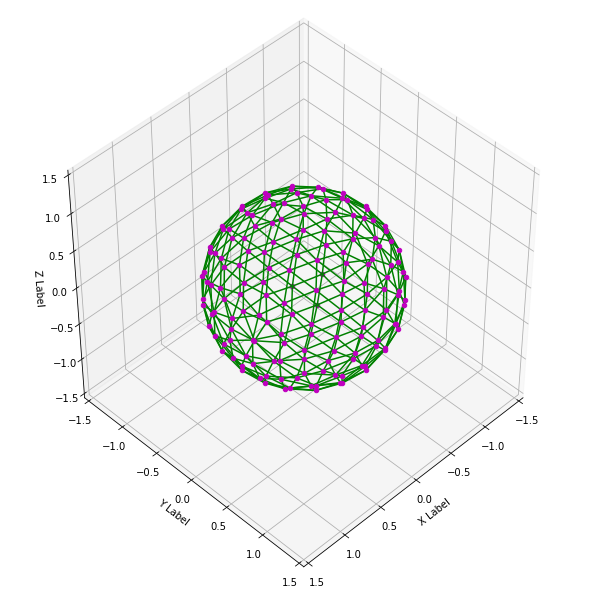

In [19]:
print_image(vertices,edges,triangles,triangle_property,nematic_vectors)